In [40]:
%run SPDEs.ipynb
%run Rule.ipynb
%run Model.ipynb
%run Noise.ipynb
%run full_visualization.ipynb
%run Algorithm_2.ipynb

In [2]:
a, b, s, t = -8, 8, 0, 10 # space-time boundaries

X_, T_ = np.linspace(a,b,1025), np.linspace(s,t,2001) # space-time grid for generating solutions
X, T = X_[::2], T_[::10] # space-time grid of observed points. O_X and O_T

k = 120 # Number of realizations

# Create realizations of initial conditions. 

IC1 = Noise().initial(40, X_, scaling = 1) # one cycle
IC2 = Noise().initial(40, X_, scaling = 2) # two cycles
IC4 = Noise().initial(40, X_, scaling = 4) # four cycles

IC = np.concatenate([IC1, IC2, IC4])

W = np.zeros((k, len(T_), len(X_)))

Burgers_ = SPDE(BC = 'P', IC = IC).Burgers(W, T = T_, X = X_) # solve Burger's equations on the fine grid

Burgers = Burgers_[:,::10,::2] # Observed points of Burger's equations

100%|██████████| 2000/2000 [00:12<00:00, 155.16it/s]


In [19]:
R = Rule(kernel_deg = 2, noise_deg = -1.5, free_num = 2) # initialize rule. No multiplicative width and forcing. 

test = np.random.choice(np.arange(120), 20, replace = False) # choose test set

experiment = IML(Burgers, Rule = R, eps = 0.1, height = 3, deg = 2.5, T = T, X = X) # initialize experiment for algorithm 2
experiment.set_train_test(test = test) # initialize test set

experiment.set_trees() # extract trees
trees = [tree for tree in experiment.trees if tree[0] != "(" and tree[1] != "'"] # leave only function of the form I[\tau]
experiment.trees = trees

experiment.initialize_Predictions() 

experiment.training_models() # Create models for Step 2 of Algorithm 2

  0%|          | 6/20000 [00:00<05:42, 58.44it/s]

Creating Model


100%|██████████| 20000/20000 [09:04<00:00, 36.71it/s] 


In [21]:
experiment.fit_training_model() # Linear fit for Step 2 of Algorithm 2

In [22]:
experiment.learn_with_fitted() # Recurcive steps 3 & 4 of Algorithm 2

100%|██████████| 20/20 [00:00<00:00, 37.14it/s]


100%|██████████| 20/20 [00:00<00:00, 40.17it/s]


In [43]:
# Translate prediction to a dataframe for the visualization class

Prediction = experiment.to_df_list()

# Translate solution to a dataframe for the visualization class
Burgers_true = [pd.DataFrame(B, index = T, columns = X) for B in Burgers]

In [44]:
# Errors

show = summary(experiment.test)
er = show.errors(Burgers_true,Prediction)
print('')
av_er = show.errors(Burgers_true,Prediction, full = False, maxi = True)

Total relative error for all test cases: 0.002557877297014253

Average error over all test cases: 0.004953730760541724

Maximum relative error among test cases: 0.01929871243009108


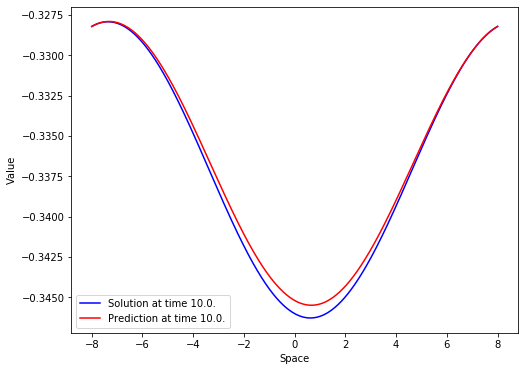

Error between solution and prediction at time 10.0 is : 0.0014795500249504211.


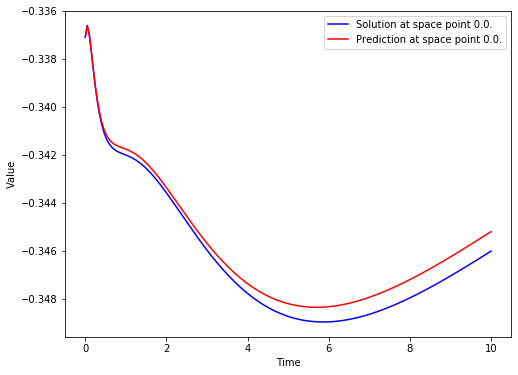

Error between solution and prediction at space point 0.0 is : 0.0016037624581849489.


In [55]:
k, t, x = 1, 200, 256
show.time_comparison(k, t, Burgers_true, Prediction, title = False)
show.space_comparison(k, x, Burgers_true, Prediction, title = False)

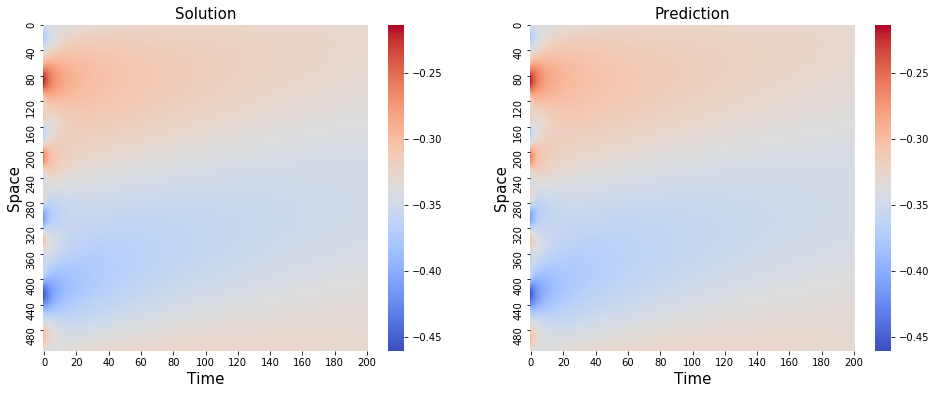

Error: 0.0011608721074962537


In [57]:
show.full_comparison(k, Burgers_true, Prediction)

In [ ]:
# Regression to determine viscosity from train cases

j = 0

u_t = np.array([(Burgers_true[i].iloc[j+1].values-Burgers_true[i].iloc[j]).values/(T[1]-T[0]) for i in range(120) if i not in test]).flatten()

dx = X[1]-X[0]

M = SPDE(BC = 'P').Parabolic_Matrix(len(X)-1, 1, dx, inverse = False)

u = np.array([Burgers_true[i].iloc[j].values for i in range(120) if i not in test])
u_xx = np.array([np.dot(M, U) for U in u]).flatten()

visc = lin_reg().fit(u_xx.reshape(-1, 1), u_t)

print("Viscocity raw:", visc.coef_)

In [ ]:
# Euler Algorithm. Functions and implemintaton

def Euler_training(Solution, T, X, train, num):
        
    dt, dx = T[1]-T[0], X[1]-X[0]

    IC = np.array([Solution[u, i, :] for u in train for i in range(len(T)-1)])
    IC_x = np.array([SPDE().discrete_diff(ic, N = len(X), flatten=True, higher = False)/dx for ic in IC])
    Non_lin1 = IC*IC_x

    Delta_IC = np.array([np.dot(SPDE(BC = "P").Parabolic_Matrix(len(X)-1, 1, dx, inverse = False), ic) for ic in IC])

    Model = []
    for i, ic in enumerate(IC):
        M = {}
        k = 0
        for j in range(0-num,0+num+1):
            M[(k,1)] = np.array([IC[i], np.roll(IC[i], j)])
            M[(k,2)] = np.array([Non_lin1[i], np.roll(Non_lin1[i], j)])
            M[(k,3)] = np.array([Delta_IC[i], np.roll(Delta_IC[i], j)])
            k+=1
        Model.append(M)

    return Model
    
def Euler(start, Solution, Prediction, T, X, test, train, num, eps, higher = False):
    
    l, dx = len(test) + len(train), X[1]-X[0]
    IC = np.zeros((l, len(X)))
    if train != []:
        IC[train] = np.array([Solution[t, start, :] for t in train])
        IC[test] = experiment.cut_off(Prediction[start].T)
    else:
        IC = experiment_n.cut_off(Prediction[start].T)
    
    IC_x = np.array([SPDE().discrete_diff(IC[i], N = len(X), flatten=True, higher = False)/dx for i in range(l)])
    
    Non_lin1 = IC*IC_x
    
    Delta_IC = np.array([np.dot(SPDE(BC = "P").Parabolic_Matrix(len(X)-1, eps, dx, inverse = False), IC[i]) for i in range(l)])
    
    Model = []
    for i in tqdm(range(l)):
        M = {}
        k = 0
        for j in range(0-num,0+num+1):
            M[(k,1)] = np.array([IC[i], np.roll(IC[i], j)])
            M[(k,2)] = np.array([Non_lin1[i], np.roll(Non_lin1[i], j)])
            M[(k,3)] = np.array([Delta_IC[i], np.roll(Delta_IC[i], j)])
            k+=1
        Model.append(M)
            
    return Model

num = 0
dummy_interval = [1,2,3]

experiment_e = IML(Burgers, eps = 0.1 R, 3, 3.5, 1)
experiment_e.set_train_test(test = test)
experiment_e.trees = [(k,i) for k in range(2*num+1) for i in dummy_interval]
experiment_e.initialize_Predictions()

experiment_e.M_train = Euler_training(Burgers_true, T, X, experiment_e.train, num, higher)

experiment_e.fit_training_model()

for i in range(0,15):
    experiment_e.M_test.append(Euler(i*experiment_e.step, experiment_e.Sol, experiment_e.Pred,
                                  experiment_e.T, experiment_e.X, experiment_e.test, [], num, 1, higher))
    experiment_e.predict_with_fitted(i, experiment_e.M_test[-1], experiment_e.Pred, experiment_e.T, experiment_e.X,
                                     experiment_e.trees, experiment_e.test, experiment_e.train)